Generative model for next-layers prediction of entire PSC cell stack sequences

Preparing dataframe with desired features/layers

In [22]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Data\Perovsite database query.csv')

# Strip whitespace from ALL string entries
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Remove rows with NaN values in key columns
df = df.dropna(subset=['Substrate_stack_sequence', 'ETL_stack_sequence', 'HTL_stack_sequence', 'Backcontact_stack_sequence', 'Perovskite_composition_long_form'])

# Define columns to keep
columns_to_keep = [
    'Cell_stack_sequence', 'Cell_architecture',
    'Substrate_stack_sequence',
    'ETL_stack_sequence', 'ETL_thickness', 'ETL_additives_compounds',
    'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients', 
    'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
    'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients', 
    'Perovskite_composition_short_form', 'Perovskite_composition_long_form', 'Perovskite_composition_leadfree', 'Perovskite_composition_inorganic',
    'Perovskite_additives_compounds', 'Perovskite_additives_concentrations', 'Perovskite_thickness', 'Perovskite_band_gap',
    'HTL_stack_sequence', 'HTL_thickness_list', 'HTL_additives_compounds',
    'Backcontact_stack_sequence',
    'Encapsulation', 'Encapsulation_stack_sequence', 'JV_default_PCE',
    'JV_default_Voc', 'JV_default_Jsc', 'JV_default_FF', 'JV_hysteresis_index'
]

# Keep only selected columns
df = df[columns_to_keep]

# Ensure all stack sequence columns are stripped of any extra spaces inside entries
for col in ['Substrate_stack_sequence', 'ETL_stack_sequence', 'HTL_stack_sequence', 'Backcontact_stack_sequence', 'Perovskite_composition_short_form']:
    df[col] = df[col].str.replace(r'\s*\|\s*', '|', regex=True)  # Remove spaces around '|'

# Now filter for common materials
df = df[
    df['Substrate_stack_sequence'].isin(['SLG|FTO', 'SLG|ITO']) &  
    df['ETL_stack_sequence'].isin(['TiO2-c|TiO2-mp', 'TiO2-c', 'PCBM-60|BCP', 'C60|BCP']) & 
    df['HTL_stack_sequence'].isin(['Spiro-MeOTAD', 'PEDOT:PSS']) &
    df['Backcontact_stack_sequence'].isin(['Au', 'Ag', 'Al', 'Carbon']) &
    df['Perovskite_composition_short_form'].isin(['MAPbI', 'CsFAMAPbBrI', 'FAMAPbBrI', 'CsPbBrI', 'MAPbBrI', 'FAPbI', 'CsFAPbBrI', 'CsPbBrI', 'CsPbI', 'CsFAPbI', 'MAPbBr']) &
    df['Cell_architecture'].isin(['nip'])       
]

# Classify perovskites into single-layered or multi-layered
ion_columns = [
    'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients', 
    'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
    'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients'
]

df['Layer Type'] = df.apply(
    lambda row: 'Multi-layered Perovskite' if any('|' in str(row[col]) for col in ion_columns) else 'Single-layered Perovskite',
    axis=1
)

# Keep only single-layered perovskites
filtered_df = df[df['Layer Type'] == 'Single-layered Perovskite']

# Create 'new cell stack' column by concatenating layers in the specified order
filtered_df['Cleaned cell stack'] = filtered_df['Substrate_stack_sequence'].astype(str) + ', ' + \
                       df['ETL_stack_sequence'].astype(str) + ', ' + \
                       df['Perovskite_composition_long_form'].astype(str) + ', ' + \
                       df['HTL_stack_sequence'].astype(str) + ', ' + \
                       df['Backcontact_stack_sequence'].astype(str)

filtered_df['Cleaned cell stack'] = filtered_df['Cleaned cell stack'].dropna().apply(lambda seq: f"<SOS>,{seq},<EOS>")

filtered_df['Perovskite_composition_long_form'] = filtered_df['Perovskite_composition_long_form'].str.strip()

# Save cleaned data
filtered_df.to_csv('cleaned_data_for_generative.csv', index=False)

C:\Users\c\AppData\Local\Temp\ipykernel_4996\450362649.py:4: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Data\Perovsite database query.csv')
C:\Users\c\AppData\Local\Temp\ipykernel_4996\450362649.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Encoding ALL layers

In [ ]:
import pandas as pd
import re
import numpy as np
import json
import pickle

# Load dataset
df = pd.read_csv(r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Generative model\cleaned_data_for_generative.csv')

# Define ions and parsing function
ions = ['MA', 'FA', 'Pb', 'Br', 'Cs', 'I']

def parse_composition(composition):
    composition_dict = {ion: 0 for ion in ions}  # Start with all ions at 0
    
    for ion in ions:
        match = re.search(f"{ion}([0-9\.]+)?", composition)  # Find the coefficient (empty string means no coefficient)
        if match:
            coeff = match.group(1)
            if coeff is None:  # If no coefficient is provided, set it to 1
                composition_dict[ion] = 1
            else:
                composition_dict[ion] = float(coeff)  # Otherwise, use the provided coefficient
    return composition_dict

# Apply parsing function to the column
df['Perovskite_composition_vector'] = df['Perovskite_composition_long_form'].apply(parse_composition)

# Function to convert the composition dict to a vector
def composition_to_vector(composition_dict):
    return np.array([composition_dict[ion] for ion in ions])

# Convert the parsed compositions to vectors
df['Perovskite_composition_vector'] = df['Perovskite_composition_vector'].apply(composition_to_vector)

# Create a flattened mapping for perovskite compositions
perovskite_mapping = dict(zip(df['Perovskite_composition_long_form'], df['Perovskite_composition_vector'].tolist()))

# Create a reverse mapping for vector to perovskite composition
perovskite_vector_to_material = {}

for perovskite, vector in zip(df['Perovskite_composition_long_form'], df['Perovskite_composition_vector']):
    perovskite_vector_to_material[tuple(vector)] = perovskite  # Store as a tuple for dict key compatibility

# Assign unique IDs to substrate, ETL, HTL, and backcontact layers

# Create a mapping for layer indications
layer_to_id = {
    'substrate': 0,
    'ETL': 1,
    'perovskite': 2,
    'HTL': 3,
    'backcontact': 4
}

material_to_id = {}
material_counter = 1

def get_material_id(material):
    global material_counter
    if material not in material_to_id:
        material_to_id[material] = material_counter
        material_counter += 1
    return material_to_id[material]

# Process cleaned cell stack and prepare vectors
full_stack_vectors = []
layer_indications = []  # To store layer indications

for stack in df['Cleaned cell stack']:
    layers = [layer.strip() for layer in stack.split(',')]  # Strip whitespace
    substrate, etl, *perovskite, htl, backcontact = layers
    
    # Layer indication vector (replace string with integer mapping)
    stack_layer_indication = [
        layer_to_id['substrate'],
        layer_to_id['ETL'],
        *[layer_to_id['perovskite']] * len(perovskite),  # Convert perovskite layers to integer IDs
        layer_to_id['HTL'],
        layer_to_id['backcontact']
    ]
    
    # Convert perovskite composition to vector
    perovskite_vector = perovskite_mapping[perovskite[0]]  # Assuming only one perovskite type per stack
    
    # Flatten perovskite vector and include in stack
    stack_vector = [
        get_material_id(substrate),
        get_material_id(etl),
        *perovskite_vector.tolist(),  # Flatten the perovskite vector
        get_material_id(htl),
        get_material_id(backcontact)
    ]
    
    # Append to full stack vectors and layer indications
    full_stack_vectors.append(stack_vector)
    layer_indications.append(stack_layer_indication)

# Store results in dataframe
df['Full stack vectors'] = full_stack_vectors
df['Layer indications'] = layer_indications  # Add layer indications to dataframe

# Save updated dataframe
df.to_csv(r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Generative model\cleaned_data_with_vectors_and_indications.csv', index=False)

print("Updated dataset saved successfully.")

<>:17: SyntaxWarning: invalid escape sequence '\.'
<>:17: SyntaxWarning: invalid escape sequence '\.'
C:\Users\c\AppData\Local\Temp\ipykernel_4996\4220620739.py:17: SyntaxWarning: invalid escape sequence '\.'
  match = re.search(f"{ion}([0-9\.]+)?", composition)  # Find the coefficient (empty string means no coefficient)


Updated dataset saved successfully.
{10}


### Predicting PCE and stability from 'Full stack vectors'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import pandas as pd
import ast
from sklearn.preprocessing import StandardScaler
import torch

# Load dataset
df = pd.read_csv(r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Generative model\cleaned_data_with_vectors.csv')  # Replace with actual dataset path

# Convert 'Full stack vectors' from string representation to list
df['Full stack vectors'] = df['Full stack vectors'].apply(ast.literal_eval)

# Drop rows with missing target variable 'JV_default_PCE'
df = df.dropna(subset=['JV_default_PCE'])

# Extract features (X) and target (Y)
X = np.array(df['Full stack vectors'].tolist(), dtype=np.float32)
Y = np.array(df['JV_default_PCE'].values, dtype=np.float32)

# Normalize perovskite composition (assuming it's from index 2 to 8)
scaler = StandardScaler()
X[:, 2:8] = scaler.fit_transform(X[:, 2:8])

# Scale the target variable 'Y'
Y = scaler.fit_transform(Y.reshape(-1, 1))  # Reshape Y to 2D before scaling

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).view(-1, 1)  # Ensure Y is 2D with shape (n_samples, 1)

# Split into train and test sets
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor, Y_tensor), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss, and optimizer
input_dim = X.shape[1]  # Assuming all vectors have the same length
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}')

Epoch 1, Loss: 0.8577
Epoch 2, Loss: 0.8107
Epoch 3, Loss: 0.8052
Epoch 4, Loss: 0.7947
Epoch 5, Loss: 0.7911
Epoch 6, Loss: 0.7921
Epoch 7, Loss: 0.7890
Epoch 8, Loss: 0.7871
Epoch 9, Loss: 0.7871
Epoch 10, Loss: 0.7842
Epoch 11, Loss: 0.7843
Epoch 12, Loss: 0.7833
Epoch 13, Loss: 0.7848
Epoch 14, Loss: 0.7824
Epoch 15, Loss: 0.7833
Epoch 16, Loss: 0.7816
Epoch 17, Loss: 0.7806
Epoch 18, Loss: 0.7795
Epoch 19, Loss: 0.7815
Epoch 20, Loss: 0.7801
Epoch 21, Loss: 0.7789
Epoch 22, Loss: 0.7769
Epoch 23, Loss: 0.7771
Epoch 24, Loss: 0.7770
Epoch 25, Loss: 0.7763
Epoch 26, Loss: 0.7761
Epoch 27, Loss: 0.7755
Epoch 28, Loss: 0.7761
Epoch 29, Loss: 0.7771
Epoch 30, Loss: 0.7746
Epoch 31, Loss: 0.7742
Epoch 32, Loss: 0.7735
Epoch 33, Loss: 0.7729
Epoch 34, Loss: 0.7729
Epoch 35, Loss: 0.7743
Epoch 36, Loss: 0.7717
Epoch 37, Loss: 0.7724
Epoch 38, Loss: 0.7715
Epoch 39, Loss: 0.7702
Epoch 40, Loss: 0.7707
Epoch 41, Loss: 0.7702
Epoch 42, Loss: 0.7721
Epoch 43, Loss: 0.7688
Epoch 44, Loss: 0.76

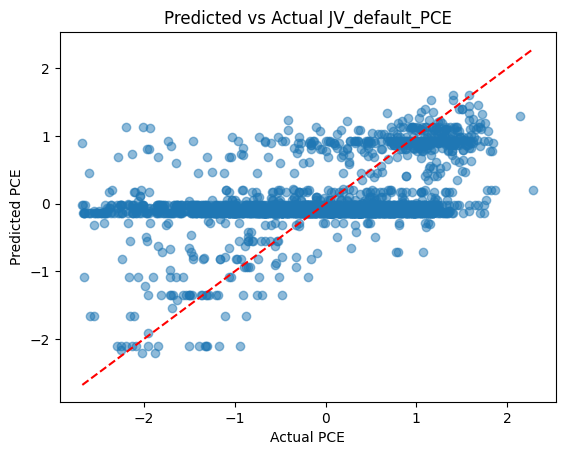

Mean Squared Error (MSE): 0.8203
R² Score: 0.2207


In [13]:
# Evaluation with actual predictions
import matplotlib.pyplot as plt

model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        preds = model(batch_X).squeeze().numpy()  # Get predictions
        actual = batch_Y.squeeze().numpy()  # Get actual values
        
        predictions.extend(preds)  
        actuals.extend(actual)  

# Convert lists to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

## plot comparison and find error/accuracy

plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel("Actual PCE")
plt.ylabel("Predicted PCE")
plt.title("Predicted vs Actual JV_default_PCE")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='dashed')  # Ideal 1:1 line
plt.show()

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Encoding the perovskite layers - K-NN CLUSTERING

In [ ]:
# Prepare for Transformer model: Define a custom embedding layer for materials

import torch
import torch.nn as nn

# Number of materials (including perovskite flattened vectors)
num_materials = len(material_to_id) + len(ions)  # Add ions for flattened perovskite vector
embedding_dim = 16  # Example embedding dimension

class MaterialEmbeddingLayer(nn.Module):
    def __init__(self, num_materials, embedding_dim):
        super(MaterialEmbeddingLayer, self).__init__()
        self.embeddings = nn.Embedding(num_materials, embedding_dim)
    
    def forward(self, x):
        return self.embeddings(x)

# Example usage
embedding_layer = MaterialEmbeddingLayer(num_materials, embedding_dim)

# Example input: Full stack vector (without flattening)
example_input = torch.tensor([material_to_id['Substrate1'], material_to_id['ETL1'], material_to_id['Pb'], material_to_id['HTL1'], material_to_id['Backcontact1']])

embedded_output = embedding_layer(example_input)

print("Embedded output:", embedded_output)


Visualiation of perovskite compositions

In [3]:
## clustering

from sklearn.cluster import KMeans

# # 11 short form comppositions = 11 clusters
# kmeans = KMeans(n_clusters=11, random_state=0)
# df['Cluster'] = kmeans.fit_predict(np.vstack(df['Perovskite_composition_vector']))

## visualise

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv(r'cleaned_data_for_generative.csv')

# Assuming 'df' has the perovskite compositions and t-SNE reduced vectors
tsne = TSNE(n_components=2, random_state=0)
reduced_vectors = tsne.fit_transform(np.vstack(df['Perovskite_composition_vector']))

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))  # Increase the figure size if needed
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=df['Cluster'], cmap='viridis')

# Add labels to each point
for i, txt in enumerate(df['Perovskite_composition_long_form']):
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], txt, fontsize=8, alpha=0.7)

# Customize the plot
plt.title('t-SNE Visualization of Perovskite Compositions')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()  # Show colorbar for cluster
plt.show()

# from sklearn.metrics import silhouette_score

# # Get the silhouette score
# silhouette_avg = silhouette_score(np.vstack(df['Perovskite_composition_vector']), df['Cluster'])
# print(f'Silhouette Score: {silhouette_avg}')

# from sklearn.metrics import davies_bouldin_score

# # Get Davies-Bouldin score
# db_index = davies_bouldin_score(np.vstack(df['Perovskite_composition_vector']), df['Cluster'])
# print(f'Davies-Bouldin Index: {db_index}')


ValueError: could not convert string to float: '[1. 0. 1. 0. 0. 3.]'

### Simplifying the model - LSTM
This LSTM-based language model (built and trained using PyTorch) will be used to generate PSC cell stacks with varied amounts of randomness, sampling from materials in the different layers. It uses a language modelling approach to predict the next 'token' (material/layer) in each sequence, learning from existing cell stacks.

1. Creating the model (using unique integer IDs)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class PSCStackDataset(Dataset):
    def __init__(self, csv_file, column_name):
        self.data = pd.read_csv(csv_file)[column_name].dropna().tolist()
        self.data = [f"<SOS>,{seq},<EOS>" for seq in self.data]  # Add special tokens
        self.vocab = self.build_vocab(self.data)
        self.encoded_data = [self.encode(seq) for seq in self.data]

    def build_vocab(self, sequences):
        unique_tokens = set(','.join(sequences).split(','))
        return {token: idx for idx, token in enumerate(unique_tokens)}

    def encode(self, sequence):
        return [self.vocab[token] for token in sequence.split(',')]

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        seq = self.encoded_data[idx]
        return torch.tensor(seq[:-1], dtype=torch.long), torch.tensor(seq[1:], dtype=torch.long)  # Shifted for prediction

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

# Temperature sampling function
def sample_with_temperature(probs, temperature=1.0):
    probs = torch.pow(probs, 1.0 / temperature)
    probs /= torch.sum(probs)
    return torch.multinomial(probs, num_samples=1).item()

# Hyperparameters
EMBED_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 2
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001

# Load dataset

dataset = PSCStackDataset(csv_file='cleaned_data_for_generative.csv', column_name='Cleaned cell stack')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model
model = LSTMModel(vocab_size=len(dataset.vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


Train the model

In [3]:
# Training loop
device = torch.device("cpu")
model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)

        loss = criterion(outputs.view(-1, len(dataset.vocab)), targets.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(dataloader):.4f}")


Epoch [1/10], Loss: 0.7025
Epoch [2/10], Loss: 0.4270
Epoch [3/10], Loss: 0.4178
Epoch [4/10], Loss: 0.4117
Epoch [5/10], Loss: 0.4085
Epoch [6/10], Loss: 0.4062
Epoch [7/10], Loss: 0.4047
Epoch [8/10], Loss: 0.4035
Epoch [9/10], Loss: 0.4028
Epoch [10/10], Loss: 0.4021


Regularisation to encourage more meaningful embeddings/representations:

In [17]:
l2_lambda = 1e-5  # Adjust this to control embedding regularization strength
embedding_loss = l2_lambda * torch.norm(model.embedding.weight, p=2)

loss = criterion(outputs.view(-1, len(dataset.vocab)), targets.view(-1)) + embedding_loss

Generate sequences:

In [18]:
def generate_sequence(model, start_token="<SOS>", max_length=15, temperature=1.0):
    model.eval()
    generated_sequence = []  
    hidden = None
    token_to_idx = dataset.vocab
    idx_to_token = {idx: token for token, idx in token_to_idx.items()}

    # Start generation
    current_token = torch.tensor([[token_to_idx[start_token]]], dtype=torch.long)

    with torch.no_grad():
        for _ in range(max_length):
            output, hidden = model(current_token, hidden)
            probs = torch.nn.functional.softmax(output[0, -1] / temperature, dim=0)
            next_token_idx = sample_with_temperature(probs, temperature)
            next_token = idx_to_token[next_token_idx]

            if next_token == "<EOS>":
                generated_sequence.append(next_token)
                break  # Stop generation when <EOS> is predicted

            generated_sequence.append(next_token)
            current_token = torch.tensor([[next_token_idx]], dtype=torch.long)

    # Ensure <EOS> is added if missing
    if generated_sequence[-1] != "<EOS>":
        generated_sequence.append("<EOS>")

    return f"<SOS>,{','.join(generated_sequence)}"

# Test different temperatures
temperatures = [0.5, 1.0, 1.5]

print("\nGenerated Sequences at Different Temperatures:")
for temp in temperatures:
    print(f"\nTemperature {temp}:")
    for i in range(3):  # Generate 3 sequences per temperature
        print(f"Sample {i+1}: {generate_sequence(model, start_token='<SOS>', max_length=15, temperature=temp)}")


Generated Sequences at Different Temperatures:

Temperature 0.5:
Sample 1: <SOS>,<SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au,<EOS>
Sample 2: <SOS>,<SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au,<EOS>
Sample 3: <SOS>,<SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au,<EOS>

Temperature 1.0:
Sample 1: <SOS>,<SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au,<EOS>
Sample 2: <SOS>,<SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au,<EOS>
Sample 3: <SOS>,<SOS>,SLG|FTO, TiO2-c, MAPbI3, Spiro-MeOTAD, Ag,<EOS>

Temperature 1.5:
Sample 1: <SOS>,<SOS>,SLG|FTO, TiO2-c, CsPbI3, Spiro-MeOTAD, Ag,<EOS>
Sample 2: <SOS>,<SOS>,<SOS>,SLG|FTO, TiO2-c|TiO2-mp, FA0.75MA0.25PbBr0.51I2.49, Spiro-MeOTAD, Ag,<EOS>
Sample 3: <SOS>,<SOS>,SLG|FTO, TiO2-c, Cs0.15FA0.85PbBr0.81I2.19, Spiro-MeOTAD, FA0.8MA0.8PbBr0.06I2.96,<EOS>


VISUALISE EMBEDDINGS??